# Packages

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import xesmf as xe
import numpy as np
import geopandas as gpd
import shapely.geometry as geom
from shapely.ops import unary_union
from scipy.stats import mannwhitneyu

# Initialising data

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'stratiform_rainfall_flux'

#exp 1 is called all var, will be SM if changed, just need to change the title of the plots 
# experiment1 = 'drysoil_d0198_RAL3P2_albedo_bare_' #all variables
experiment1 = 'drysoil_d0198_RAL3P2_'  #soil moisture
allvar = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')[variable]
allvar = allvar.assign_coords(time=allvar['time'] + pd.Timedelta(hours=10))

experiment2 = 'control_d0198_RAL3P2_' #experiment name
control = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')[variable]
control = control.assign_coords(time=allvar['time'] + pd.Timedelta(hours=10))

In [3]:
variable2 = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')[variable2].isel(time=0)

#clip to just land 
variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)
allvar = allvar.where(landmask == 1)
control = control.where(landmask == 1)

fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')

In [4]:
allvar = allvar *3600
control = control *3600

In [4]:
# fires = gpd.read_file("/g/data/ng72/as9583/total_fires.gpkg")
# #merging overlapping polygons
# merged_fires = unary_union(fires.geometry)

In [5]:
# #done once, doesnt need to happen again
# from shapely.geometry import MultiPolygon

# # Wrap MultiPolygon in a GeoDataFrame
# gdf_merged = gpd.GeoDataFrame(geometry=[merged_fires])

# # Assign CRS (match your original fires)
# gdf_merged.set_crs(fires.crs, inplace=True)

# # Save to GeoPackage
# gdf_merged.to_file("/g/data/ng72/as9583/merged_fires.gpkg", driver="GPKG")

# Plots

## Whole period

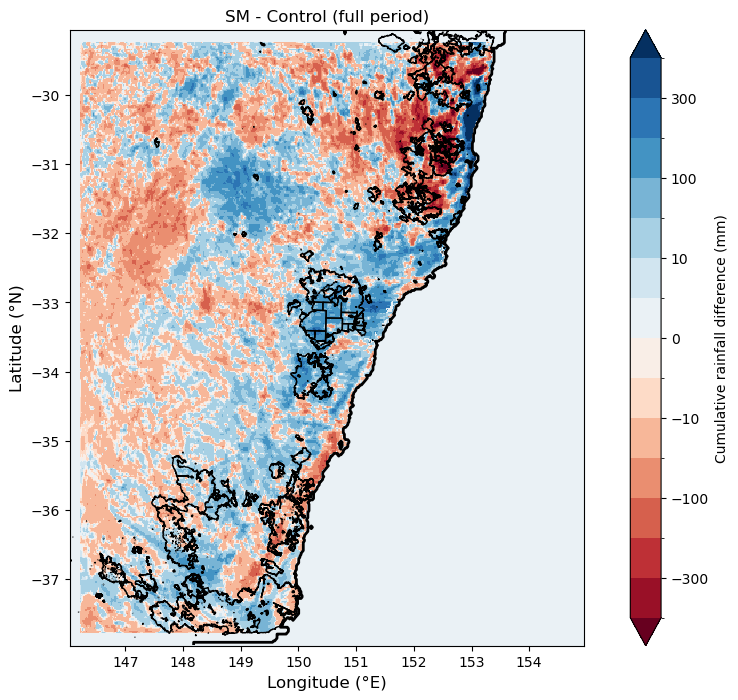

In [6]:
#convert to mm/hour and sum across model period
allvar_total = (allvar * 3600).sum(dim="time", skipna=True)
control_total = (control * 3600).sum(dim="time", skipna=True)

#difference 
diff_total = allvar_total - control_total


fig, ax = plt.subplots(figsize=(12, 8))
diff_total.plot(
    ax=ax,
    cmap='RdBu',
    center=0,
    levels=[-400, -300, -200, -100, -50, -10, -5, 0, 5, 10, 50, 100, 200, 300, 400],
    extend='both',
    cbar_kwargs={'label': 'Cumulative rainfall difference (mm)'}
)

contours2 = sa1.plot.contour(ax=ax, levels=[0], colors='black', linewidths=2, add_colorbar=False)

gpd.GeoSeries(fires.boundary).plot(
    ax=ax, edgecolor="black", linewidth=1
)

plt.title("SM - Control (full period)")
plt.xlabel("Longitude (°E)", fontsize=12)
plt.ylabel("Latitude (°N)", fontsize=12)
plt.show()


## Difference during big event (Feb 8-13)

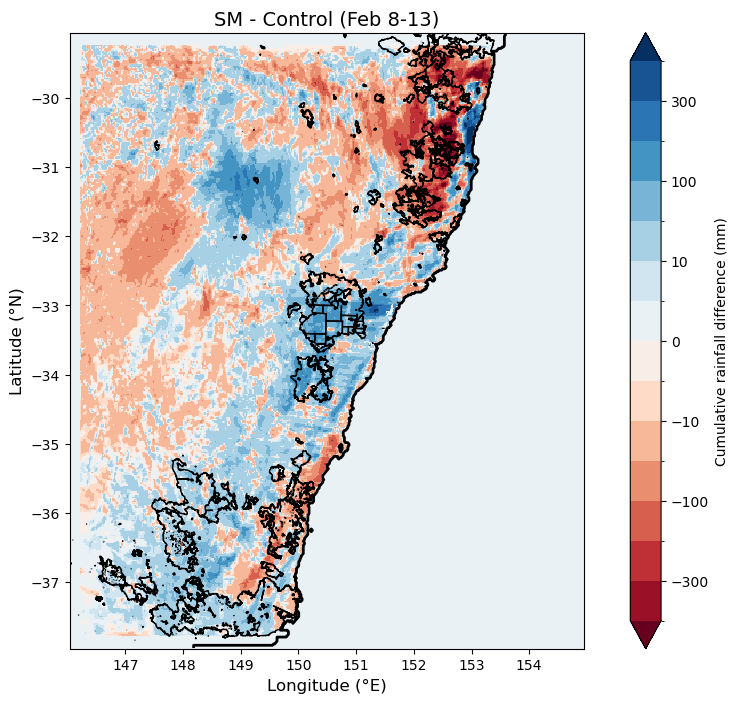

In [7]:
start_date = '2020-02-08'
end_date = '2020-02-13'

allvar_feb = allvar.sel(time=slice(start_date, end_date))
control_feb = control.sel(time=slice(start_date, end_date))

allvar_feb = (allvar_feb * 3600).sum(dim="time", skipna=True)
control_feb = (control_feb * 3600).sum(dim="time", skipna=True)

diff_feb = allvar_feb - control_feb

fig, ax = plt.subplots(figsize=(12, 8))
diff_feb.plot(
    ax=ax,
    cmap='RdBu',
    center=0,
    levels=[-400, -300, -200, -100, -50, -10, -5, 0, 5, 10, 50, 100, 200, 300, 400],
    extend='both',
    cbar_kwargs={'label': 'Cumulative rainfall difference (mm)'}
)

contours2 = sa1.plot.contour(ax=ax, levels=[0], colors='black', linewidths=2, add_colorbar=False)

gpd.GeoSeries(fires.boundary).plot(
    ax=ax, facecolor="none", edgecolor="black", linewidth=1
)

plt.title("SM - Control (Feb 8-13)", fontsize=14)
plt.xlabel("Longitude (°E)", fontsize=12)
plt.ylabel("Latitude (°N)", fontsize=12)
plt.show()

## Difference before big event (Jan 13 - Feb 7)

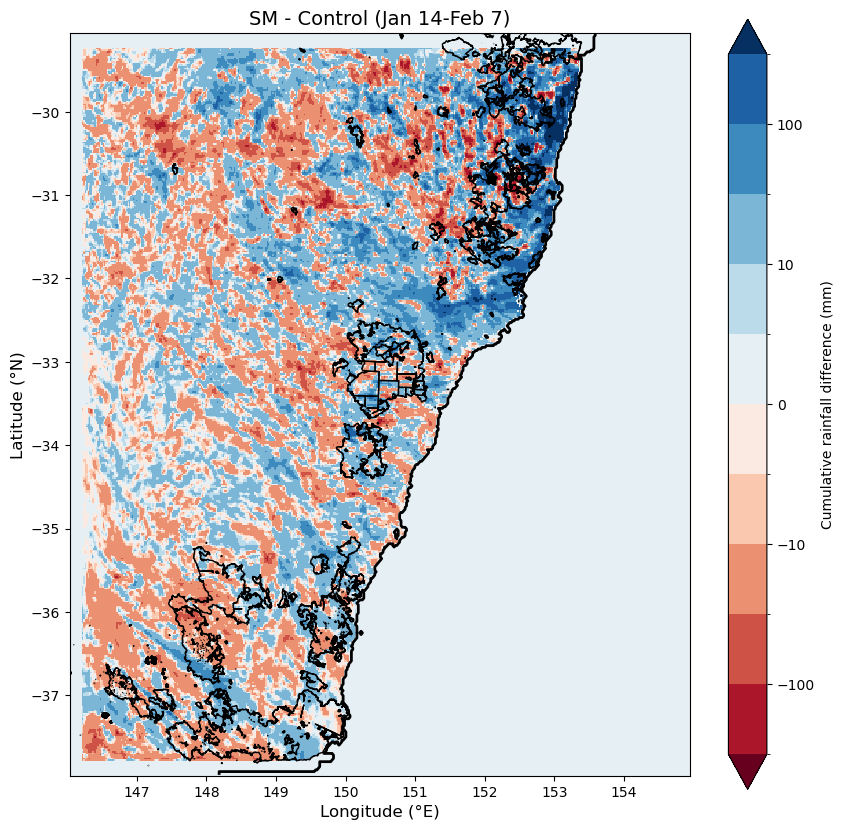

In [8]:
start_date = '2020-01-14'
end_date = '2020-02-07'

allvar_jan = allvar.sel(time=slice(start_date, end_date))
control_jan = control.sel(time=slice(start_date, end_date))

allvar_jan = (allvar_jan * 3600).sum(dim="time", skipna=True)
control_jan = (control_jan * 3600).sum(dim="time", skipna=True)

diff_jan = allvar_jan - control_jan

fig, ax = plt.subplots(figsize=(10,10))
diff_jan.plot(
    ax=ax,
    cmap='RdBu',
    center=0,
    levels=[-200, -100, -50, -10, -5, 0, 5, 10, 50, 100, 200],
    extend='both',
    cbar_kwargs={'label': 'Cumulative rainfall difference (mm)'}
)

contours2 = sa1.plot.contour(ax=ax, levels=[0], colors='black', linewidths=2, add_colorbar=False)

gpd.GeoSeries(fires.boundary).plot(
    ax=ax, facecolor="none", edgecolor="black", linewidth=1
)

plt.title("SM - Control (Jan 14-Feb 7)", fontsize=14)
plt.xlabel("Longitude (°E)", fontsize=12)
plt.ylabel("Latitude (°N)", fontsize=12)
plt.show()

In [9]:
# note different scales between pre- and during- event rainfall ^^^

In [5]:
start_date_feb = '2020-02-07'
end_date_feb = '2020-02-13'

start_date_jan = '2020-01-16'
end_date_jan = '2020-01-21'

def significance_mask(exp, control, start_date, end_date, alpha=0.05):
    # Select time window
    exp_sel = exp.sel(time=slice(start_date, end_date))
    ctrl_sel = control.sel(time=slice(start_date, end_date))
    
    #Initialize array to store p-values
    p_values = xr.full_like(exp_sel.isel(time=0), np.nan)
    
    # Loop over grid points
    for lat_idx in range(exp_sel.latitude.size):
        for lon_idx in range(exp_sel.longitude.size):
            exp_vals = exp_sel[:, lat_idx, lon_idx].values
            ctrl_vals = ctrl_sel[:, lat_idx, lon_idx].values
            
            # Remove NaNs
            if np.isnan(exp_vals).all() or np.isnan(ctrl_vals).all():
                continue
            exp_vals = exp_vals[~np.isnan(exp_vals)]
            ctrl_vals = ctrl_vals[~np.isnan(ctrl_vals)]
            
            # Perform Mann–Whitney U test
            if len(exp_vals) > 1 and len(ctrl_vals) > 1:
                stat, p = mannwhitneyu(exp_vals, ctrl_vals, alternative='two-sided')
                p_values[lat_idx, lon_idx] = p
                
    # Create significance mask (True = significant)
    sig_mask = (p_values < alpha)
    return sig_mask

# --- Apply for both events ---
sigmask_jan = significance_mask(allvar, control, start_date_jan, end_date_jan)
sigmask_feb = significance_mask(allvar, control, start_date_feb, end_date_feb)


sigmask_jan_bool = (sigmask_jan == True) & (landmask == 1)
sigmask_feb_bool = (sigmask_feb == True) & (landmask == 1)

In [23]:
import matplotlib.patheffects as path_effects


# Add white outline around te

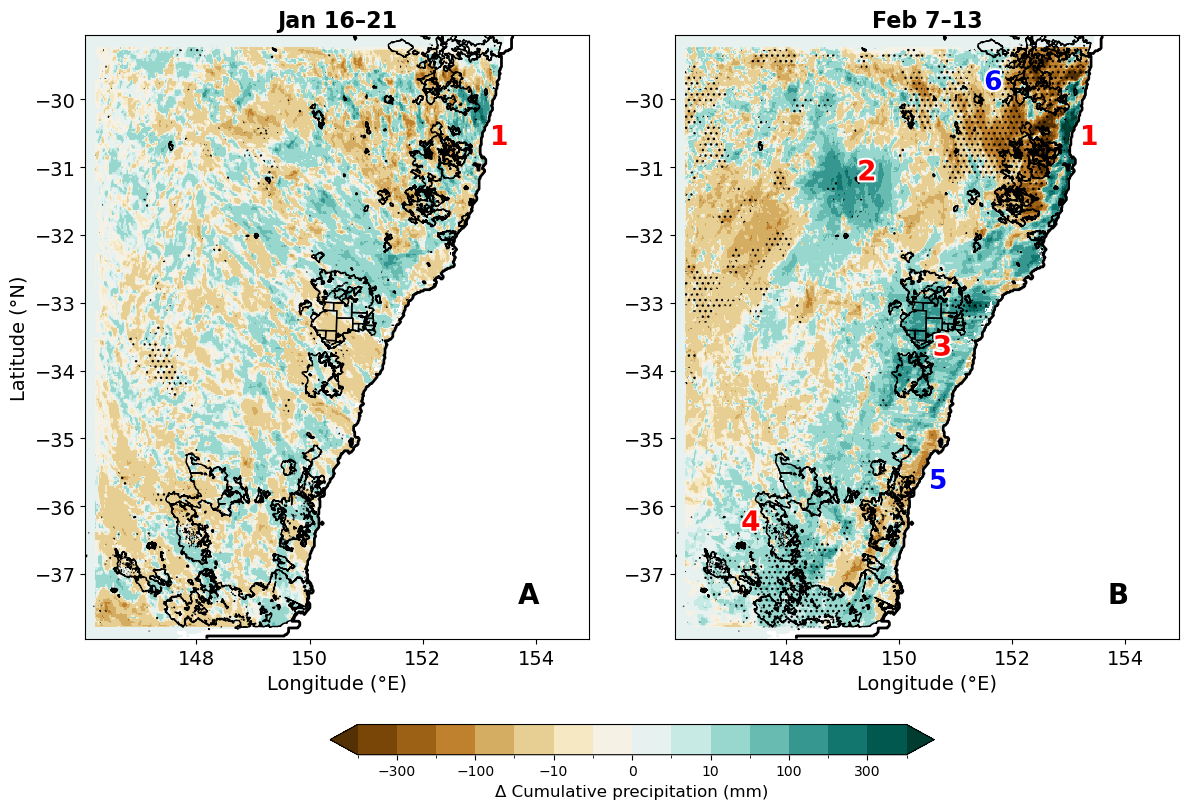

In [30]:
start_date_feb = '2020-02-07'
end_date_feb = '2020-02-13'

start_date_jan = '2020-01-16'
end_date_jan = '2020-01-21'

# --- FEBRUARY ---
allvar_feb = allvar.sel(time=slice(start_date_feb, end_date_feb))
control_feb = control.sel(time=slice(start_date_feb, end_date_feb))
allvar_feb = allvar_feb.sum(dim="time", skipna=True)
control_feb = control_feb.sum(dim="time", skipna=True)
diff_feb = allvar_feb - control_feb
diff_feb = diff_feb.where(landmask == 1)

# --- JANUARY ---
allvar_jan = allvar.sel(time=slice(start_date_jan, end_date_jan))
control_jan = control.sel(time=slice(start_date_jan, end_date_jan))
allvar_jan = allvar_jan.sum(dim="time", skipna=True)
control_jan = control_jan.sum(dim="time", skipna=True)
diff_jan = allvar_jan - control_jan
diff_jan = diff_jan.where(landmask == 1)

# --- PLOTTING ---
fig, axes = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True)


# Common settings
cmap = 'BrBG'
levels = [-400, -300, -200, -100, -50, -10, -5, 0, 5, 10, 50, 100, 200, 300, 400]

# --- Left: January ---
im1 = diff_jan.plot(
    ax=axes[0],
    cmap=cmap,
    center=0,
    levels=levels,
    extend='both',
    add_colorbar=False
)
sigmask_jan_bool.plot.contourf(
    ax=axes[0],
    levels=[0.5, 1],
    hatches=["", "..."],  # adds diagonal hatching
    colors="none",
    add_colorbar=False
)
sa1.plot.contour(ax=axes[0], levels=[0], colors='black', linewidths=2, add_colorbar=False)
gpd.GeoSeries(fires.boundary).plot(ax=axes[0], facecolor="none", edgecolor="black", linewidth=1)
axes[0].set_title("Jan 16–21", fontsize=16, fontweight = 'bold')
axes[0].set_xlabel("Longitude (°E)", fontsize=14)
axes[0].set_ylabel("Latitude (°N)", fontsize=14)
axes[0].text(
    0.9,0.05,
    "A",
    fontsize=20,
    transform=axes[0].transAxes,
    fontweight='bold',
    va='bottom',
    ha='right',
    color = 'black')
axes[0].text(0.84, 0.81, "1", fontsize=19, transform=axes[0].transAxes, fontweight='bold', va='bottom', ha='right', color = 'red')

# --- Right: February ---
im2 = diff_feb.plot(
    ax=axes[1],
    cmap=cmap,
    center=0,
    levels=levels,
    extend='both',
    add_colorbar=False
)
sigmask_feb_bool.plot.contourf(
    ax=axes[1],
    levels=[0.5, 1],
    hatches=["", "..."],  # adds diagonal hatching
    colors="none",
    add_colorbar=False
)
sa1.plot.contour(ax=axes[1], levels=[0], colors='black', linewidths=2, add_colorbar=False)
gpd.GeoSeries(fires.boundary).plot(ax=axes[1], facecolor="none", edgecolor="black", linewidth=1)
axes[1].set_title("Feb 7–13", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Longitude (°E)", fontsize=14)
axes[1].set_ylabel("")
axes[1].text(
    0.9,0.05,
    "B",
    fontsize=20,
    transform=axes[1].transAxes,
    fontweight='bold',
    va='bottom',
    ha='right',
    color = 'black')

#numbers 
axes[1].text(0.84, 0.81, "1", fontsize=19, transform=axes[1].transAxes, fontweight='bold', va='bottom', ha='right', color = 'red')

two = axes[1].text(0.4, 0.75, "2", fontsize=20, transform=axes[1].transAxes, fontweight='bold', va='bottom', ha='right', color = 'red')
two.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

three = axes[1].text(0.55, 0.46, "3", fontsize=20, transform=axes[1].transAxes, fontweight='bold', va='bottom', ha='right', color = 'red')
three.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

four = axes[1].text(0.17, 0.17, "4", fontsize=20, transform=axes[1].transAxes, fontweight='bold', va='bottom', ha='right', color = 'red')
four.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

axes[1].text(0.54, 0.24, "5", fontsize=19, transform=axes[1].transAxes, fontweight='bold', va='bottom', ha='right', color = 'blue')
six = axes[1].text(0.65, 0.9, "6", fontsize=19, transform=axes[1].transAxes, fontweight='bold', va='bottom', ha='right', color = 'blue')
six.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

axes[0].tick_params(axis='both', labelsize=14)
axes[1].tick_params(axis='both', labelsize=14)


# Add shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label('Δ Cumulative precipitation (mm)', fontsize=12)
# plt.savefig('/g/data/ng72/as9583/new_analysis/figures/event_SM_control.png', dpi = 300, bbox_inches='tight')

plt.show()


## 90% 

In [7]:
#jan 90%
p5_diff = np.nanpercentile(diff_jan, 5)
p95_diff = np.nanpercentile(diff_jan, 95)

print(f"SM vs Control during Jan:")
print(f"  5th percentile difference: {p5_diff:.2f} mm (below control)")
print(f" 95th percentile difference: {p95_diff:.2f} mm (above control)")

SM vs Control during Jan:
  5th percentile difference: -45.30 mm (below control)
 95th percentile difference: 38.33 mm (above control)


In [8]:
#feb 90%
p5_diff = np.nanpercentile(diff_feb, 5)
p95_diff = np.nanpercentile(diff_feb, 95)

print(f"SM vs Control during Feb:")
print(f"  5th percentile difference: {p5_diff:.2f} mm (below control)")
print(f" 95th percentile difference: {p95_diff:.2f} mm (above control)")

SM vs Control during Feb:
  5th percentile difference: -99.95 mm (below control)
 95th percentile difference: 95.55 mm (above control)
